In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from defs_cori import *

In [8]:
curr_dir = os.getcwd()+'/'

# Langevin evolution Plotting

import the csv

In [10]:
filename = "nrrb_data_test/logfile_D_2_Nx_41_Nt_160_dt_0.05_nL_1000_eps_0.001_m_1_wtr_0_wz_0_l_0_mu_-0.01.log"
input_filename = "nrrb_data_test/inputs_test"
p = extract_parameters(curr_dir,input_filename)
data_tL = pd.read_csv(curr_dir+filename)
data_tL = data_tL.rename(columns={"#step": "step"})
data_tL = data_tL.drop(columns=["Unnamed: 9"])

In [11]:
data_tL.head()

,step,Re[phi^{*}phi],Im[phi^{*}phi],Re[<n>],Im[<n>],Re[<Lz>],Im[<Lz>],Re[<S>],Im[<S>]
0,0,0.000335,-0.000036,-0.000396,-0.000111,0.003020,0.000375,0.005415,0.020109
1,1,0.002287,0.000024,-0.000384,-0.000100,0.000897,0.000576,0.085907,0.021442
2,2,0.004301,0.000062,-0.000304,0.000004,0.002668,-0.000745,0.168638,0.025155
3,3,0.006398,0.000079,-0.000230,0.000027,0.000833,0.002079,0.253916,0.025822
4,4,0.008437,-0.000031,-0.000095,0.000077,0.003380,0.003467,0.339173,0.018641


Add a column for the Langevin time, steps scaled by the Langevin stepsize

In [14]:
eps = p["eps"]
tL = data_tL.step*eps
data_tL['tL'] = tL
data_tL.head()

,step,Re[phi^{*}phi],Im[phi^{*}phi],Re[<n>],Im[<n>],Re[<Lz>],Im[<Lz>],Re[<S>],Im[<S>],tL
0,0,0.000335,-0.000036,-0.000396,-0.000111,0.003020,0.000375,0.005415,0.020109,0.000
1,1,0.002287,0.000024,-0.000384,-0.000100,0.000897,0.000576,0.085907,0.021442,0.001
2,2,0.004301,0.000062,-0.000304,0.000004,0.002668,-0.000745,0.168638,0.025155,0.002
3,3,0.006398,0.000079,-0.000230,0.000027,0.000833,0.002079,0.253916,0.025822,0.003
4,4,0.008437,-0.000031,-0.000095,0.000077,0.003380,0.003467,0.339173,0.018641,0.004


Plot real and imaginary density as a function of Langevin time to identify thermalization point. Running averages will be slightly off since they are computed without throwing away the thermalization period yet.

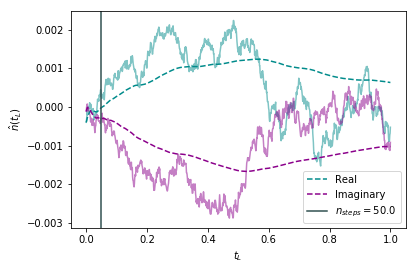

In [15]:
fig, ax = plt.subplots()
nRe = data_tL['Re[<n>]']
nIm = data_tL['Im[<n>]']
tL =  data_tL['tL']  
steps = np.arange(1,len(tL)+1)
ra_Re = np.cumsum(nRe)/steps
ra_Im = np.cumsum(nIm)/steps
ax.plot(tL, nRe, color = "darkcyan",alpha =0.5,label='_nolegend_')
ax.plot(tL, nIm, color = "darkmagenta",alpha =0.5,label='_nolegend_')
ax.plot(tL, ra_Re, ls='dashed', color = "darkcyan", label = "Real")
ax.plot(tL, ra_Im, ls='dashed', color = "darkmagenta", label = "Imaginary")
#determine thermalization point and draw a line on the plot to show it
therm_step = 0.05/eps
ax.axvline(x=0.05, color = "darkslategray", label = "$n_{steps} = $"+str(therm_step))
ax.legend()
ax.set_xlabel("$t_{L}$")
ax.set_ylabel(r"$\hat{n}(t_{L})$")
plt.show()